<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/project5/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graduation Project: Image Processing with Convolutional Neural Networks

Images of happy, shocked & sad faces will be analysed by Convolutional Neural Networks.<br>When satisfactory amount of accuracy is achieved, we are going to save that particular model and use it on our camera.

---
# 1\. Introduction

## 1.1 Importing Files & Modules

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/MertColab/project5/"

Mounted at /content/drive/
/content/drive/My Drive/MertColab/project5


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os, io
import cv2
from zipfile import ZipFile
from PIL import Image

## 1.2 Getting the dataset ready

In [ ]:
shock_zip = ZipFile("shock.zip", "r")
happy_zip = ZipFile("happy.zip", "r")
sad_zip = ZipFile("sad.zip", "r")

In [ ]:
shock_img = []
happy_img = []
sad_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip), 
                            (shock_img, happy_img, sad_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, code=8) if len(img.shape) != 3 else img    #note
        var_img.append(img)
shock_img = np.asarray(shock_img)
happy_img = np.asarray(happy_img)
sad_img = np.asarray(sad_img)

In the "noted" line above, <code>code = 8</code> refers to <code>cv2.COLOR_GRAY2BGR</code> (see the [link](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html)).<br>This conversation is required since there seems to be 8bpp images in the dataset. The rest is in 24bpp (RGB).

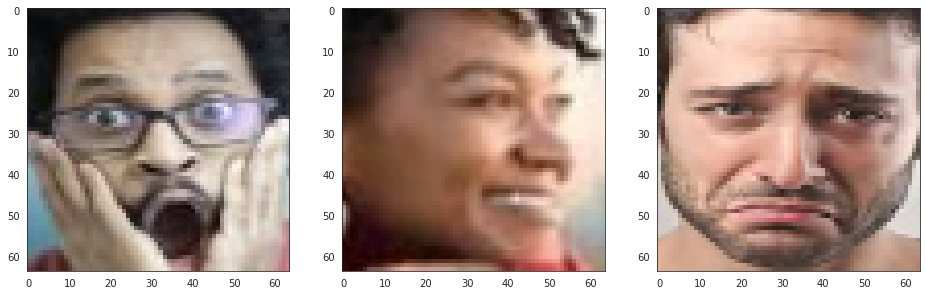

In [ ]:
# 3 random images from each class
sns.set_style(style="white")
plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(shock_img[np.random.randint(0,150)])
plt.subplot(1,3,2)
plt.imshow(happy_img[np.random.randint(0,150)])
plt.subplot(1,3,3)
plt.imshow(sad_img[np.random.randint(0,150)])
plt.show()

***
## 1.3 Train & Test Set

We are going to create an **X_train** which will contain arrays of the images & a **y_train** to hold the label numbers. There will be some points that need to be paid close attention.

0) There are 1180 images *(180 of them are original and 1000 of them are generated from the originals)* for each category.

1) Both **X_train** & **y_train** will be sequential! First 1180 images will belong to *sad* class, the second 1180 is for the *shock* class and the last sequence corresponds to the *happy* people. Thus, while training the model (or even before), one should remember to shuffle the batches to avoid any obstacle on the learning path.

2) **y_train** has only numbers, which are **0**, **1** and **2**. These are the *sad*, *shocked* & *happy* classes, respectively.

3) About 750 images will be chosen for the test set.

In [ ]:
X_train = np.concatenate([sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*1180 + [1]*1180 + [2]*1180)
# in case of dimensional error:
# y_train = np.array([0]*1180 + [1]*1180 + [2]*1180, ndmin=2).T

# 750 pictures in total will be chosen for the test set
# first we get the random indices:
random_num_sad = np.random.choice(range(0, 1180), 250, replace=False)
random_num_shock = np.random.choice(range(1180, 2360), 250, replace=False)
random_num_happy = np.random.choice(range(2360, 3540), 250, replace=False)
random_indices = np.concatenate([random_num_sad,
                                 random_num_shock,
                                 random_num_happy])
# test set is ready:
X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set:
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

# Do not forget to shuffle the set:
def shuffle_set():
    # to make sure the shuffle is the same for both of them,
    random_state = np.random.get_state()
    np.random.shuffle(X_train)
    np.random.shuffle(X_test)
    # we keep the random state and pass it to the next step:
    np.random.set_state(random_state)
    np.random.shuffle(y_train)
    np.random.shuffle(y_test)
shuffle_set()

# ...and we dispose of these temporary tools:
del (random_num_sad, random_num_shock, 
     random_num_happy, random_indices, shuffle_set)

## 1.4 Image Generation
Since we don't have many images, we create the new ones by Keras' ImageDataGenerator module.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img

In [ ]:
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=10,    # adjusted
    width_shift_range=0.10,    # adjusted
    height_shift_range=0.10,    # adjusted
    brightness_range=(0.85, 1.15),    # adjusted
    shear_range=0.02,    # adjusted
    zoom_range=0.10,    # adjusted
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,    # adjusted
    vertical_flip=False,
    rescale=1.0/255,    # adjusted
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,    # adjusted
    dtype=None,
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

Some example of generated pictures:

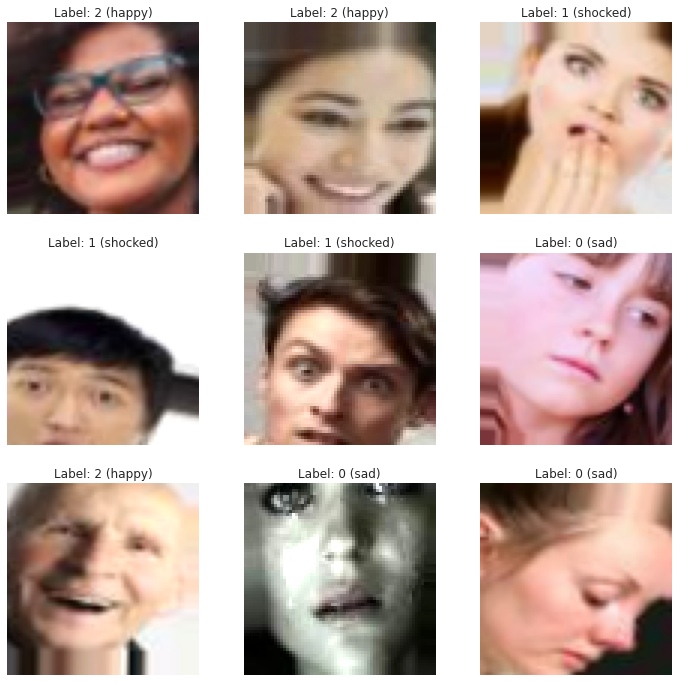

In [ ]:
# https://keras.io/api/preprocessing/image/#flow-method
train_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=32, 
                                     shuffle=True,
                                     seed=None, 
                                     subset="training",
                                     )
validation_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=32, 
                                     shuffle=True,
                                     seed=None, 
                                     subset="validation",
                                     )
test_generator = test_datagen.flow(x=X_test, y=y_test, 
                                     batch_size=4, 
                                     shuffle=True, 
                                     seed=None,
                                     )
sns.set_style(style="white")
plt.figure(figsize=(12,12))
for i, picture in enumerate(train_generator):
    plt.subplot(3,3,i+1)
    plt.imshow(array_to_img(picture[0][0]))
    label_num = picture[1][0]
    label_str = "happy" if label_num==2 else "shocked" if label_num else "sad" 
    plt.title(f"Label: {label_num} ({label_str})")
    plt.axis("off")
    if i == 8:
        break
plt.show()

In [ ]:
# this block was used for generating and saving images:
# 1000 more images were generated
# note to self: Ctrl+Shift+7 to uncomment them all

# for label_num, folder, images in ((0, "sad", sad_img),
#                                   (1, "sho", shock_img),
#                                   (2, "hap", happy_img)):
#     XXX = np.array(images)
#     YYY = np.array([label_num]*180)
#     train_generator = train_datagen.flow(x=XXX, y=YYY, 
#                                         batch_size=1, 
#                                         shuffle=True,
#                                         save_to_dir=("gen_img/"+folder), 
#                                         save_prefix="", 
#                                         save_format="jpg", 
#                                         seed=None,
#                                         )
#     for i, picture in enumerate(train_generator):
#         if i == 999:
#             break

# 2\. Creating The Model

## 2.1 Shape of The Dataset

In [ ]:
from keras import models, layers

In [ ]:
print("---Shape of the train set---\nX_train:", X_train.shape, 
      "\ny_train:", y_train.shape)
print("\n---Shape of the test set---\nX_test:", X_test.shape, 
      "\ny_test:", y_test.shape)

---Shape of the train set---
X_train: (2790, 64, 64, 3) 
y_train: (2790,)

---Shape of the test set---
X_test: (750, 64, 64, 3) 
y_test: (750,)


## 2.2 Neural Network Models

### 2.2.0 TensorBoard Configuration & Monitoring

Here we prepare the TensorBoard configuration to monitor the model's performance below. After creating the model, we will refer to TensorBoard API.

Self reminders:
* To view open TensorBoard instances: <code>tb_notebook.list()</code>

* To kill the current TensorBoard process: <code>!kill #</code> (#:pid number)

* To control TensorBoard display: <code>tb_notebook.display(port=None, height=1000)</code> 
If no port is provided, the most recently launched TensorBoard is used.

In [ ]:
from keras.callbacks import TensorBoard
from tensorboard import notebook as tb_notebook

In [ ]:
# Load the TensorBoard notebook extension:
%load_ext tensorboard

#### 2.2.0.1 TensorBoard

In [ ]:
# To run the TensorBoard:
## %tensorboard --logdir my_log_dir

***Note: To turn on the TensorBoard, please delete the double hashtag (##) above.***

Here let me put a snippet of a TensorBoard working on training the data. I thought there was no point of using the original TB instance since GitHub is not able to show it on the page. Also it bloats the .ipynb file over 10 MB.

 ![TensorBoard Snippet](https://i.pinimg.com/originals/7e/8b/d7/7e8bd72b51e0bf7a65e0f8471d2779b2.jpg)

### 2.2.1 A Standart, Baseline Model
We have only a couple of convolutional and a pooling layer in the baseline model.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

When/If needed, we are going to change the parameters in these functions. <br>Otherwise, they just will be called on demand for our newly created models.

In [ ]:
def compile_model(model_number="(null)"):
    model.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
    # TensorBoard configuration:
    # create a folder for log files
    my_log_dir = os.path.join("my_log_dir", 
                        datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S" + 
                                                         model_number))
    tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, histogram_freq=1)
    # fit the set:
    model_history = model.fit(train_generator, 
                    batch_size=32, 
                    epochs=500, 
                    verbose=0, 
                    validation_data=validation_generator,
                    callbacks=[tensorboard_callbacks]
                    )
    return model_history

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


In [ ]:
model_history = compile_model("(1)")

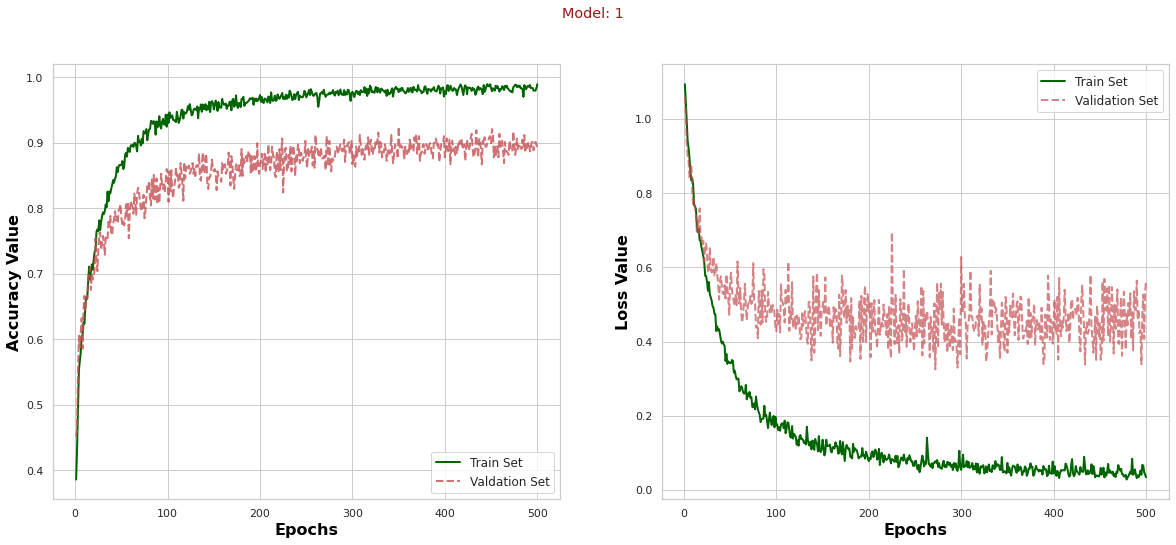

In [ ]:
# cosmetic configuration
def display_graph(model_number="(null)"):
    sns.set(style="whitegrid")
    title_font = {"family":"sans", 
                "color":"darkred", 
                "size":30, 
                "weight":"bold", 
                "alpha":0.9}
    axis_font = {"family":"sans-serif", 
                "color":"black", 
                "size":16, 
                "weight":"bold"}

    # plot the graphs
    plt.figure(figsize=(20,8))
    plt.suptitle("Model: " + model_number, fontdict=title_font)
    plt.subplot(1,2,1)
    plt.plot(range(1, len(model_history.history["accuracy"])+1), 
            model_history.history["accuracy"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_accuracy"])+1), 
            model_history.history["val_accuracy"], 
            "r--", linewidth=2, label="Valdation Set", alpha=0.8)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Accuracy Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.subplot(1,2,2)
    plt.plot(range(1, len(model_history.history["loss"])+1), 
            model_history.history["loss"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_loss"])+1), 
            model_history.history["val_loss"], 
            "r--", linewidth=2, label="Validation Set", alpha=0.7)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Loss Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.show()

In [ ]:
display_graph("1")

### 2.2.2 Model Number 2
Dropout layers are activated.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)       

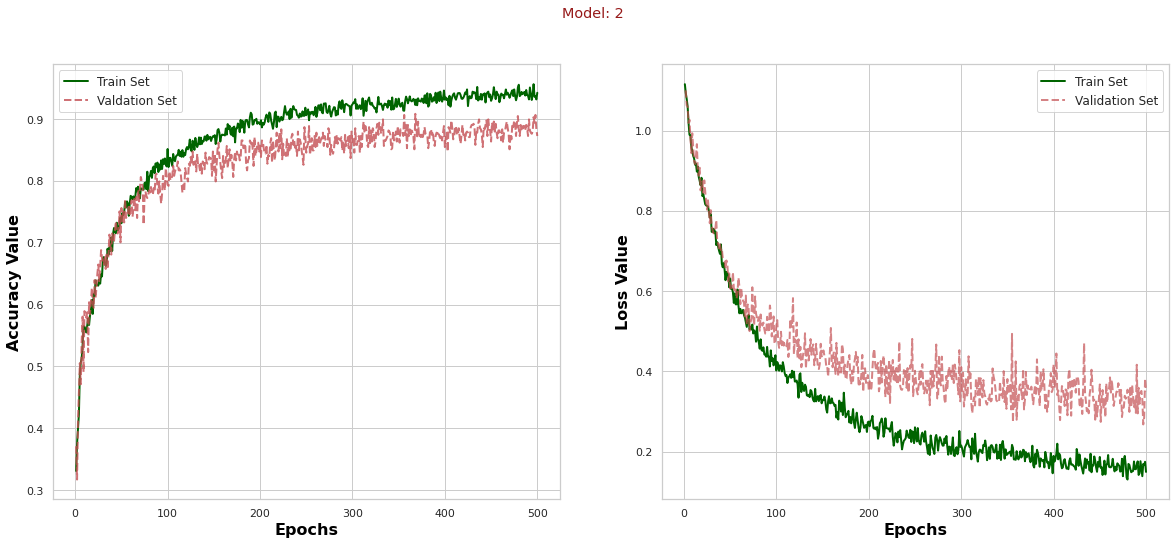

In [ ]:
model_history = compile_model("(2)")
display_graph("2")

### 2.2.3 Model Number 3
We will give BatchNormalization() a shot.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)         

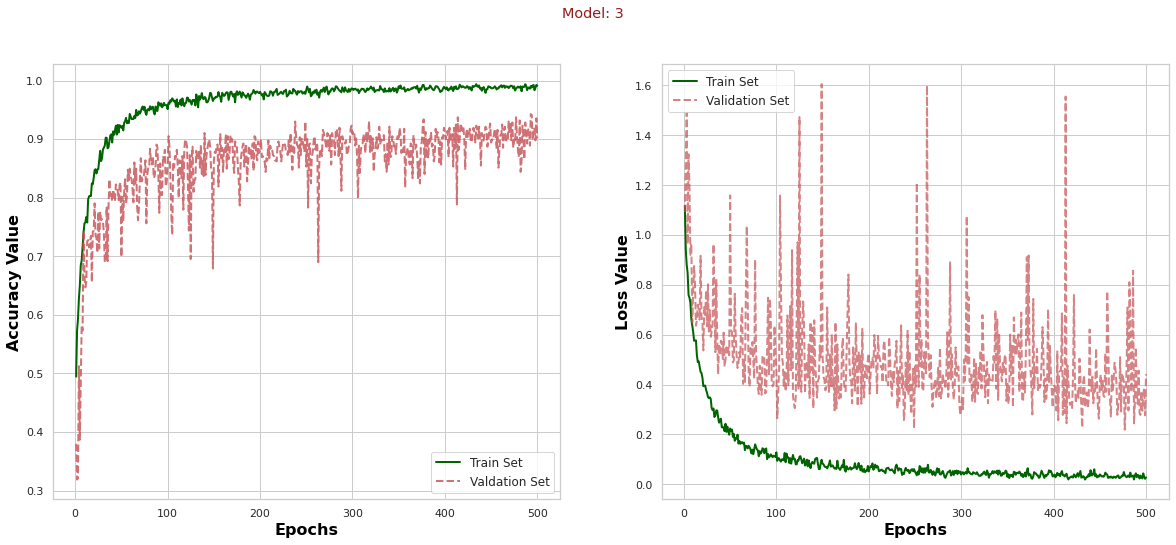

In [ ]:
model_history = compile_model("(3)")
display_graph("3")

### 2.2.4 Model Number 4
Let's try a few regularization techniques. Actually, we'll go for L2 regularization only since we know from the baseline model, a severe overfitting is not the case here.

In [ ]:
from keras import regularizers

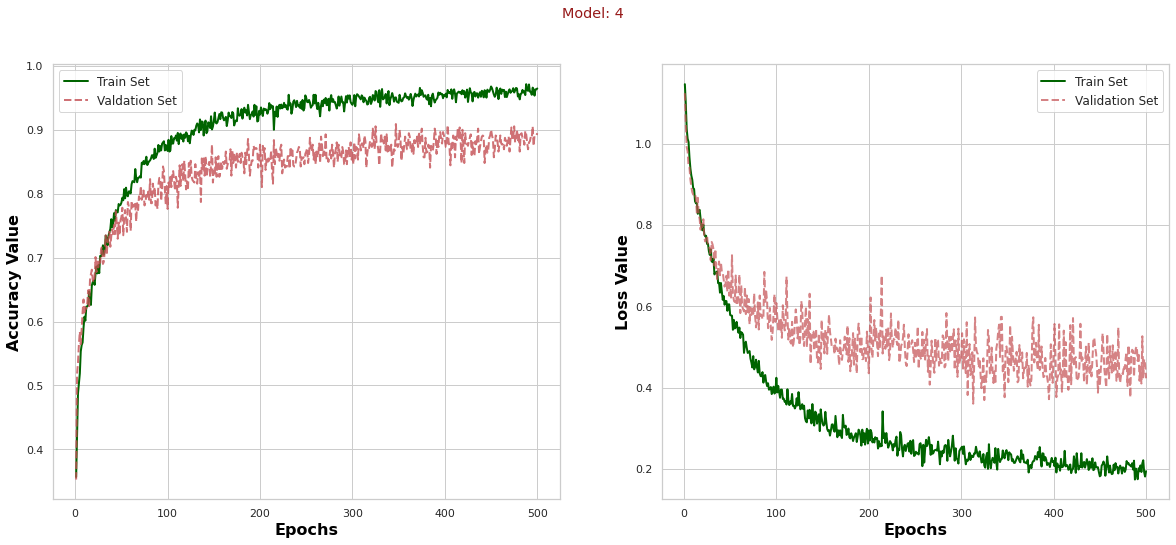

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),  
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        kernel_regularizer=regularizers.l2(0.001), 
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=regularizers.l2(0.001), 
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu", 
                       kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

model_history = compile_model("(4)")
display_graph("4")

# 3\. Evaluation
Now we are going to try to improve the model by adapting the best parts of previous attempts by adding/removing hidden layers, neurons and so on. When it's done, the final model will be run and saved for good.

## 3.1 Fine Tuning
After a few finishing touches, the last model will be ready. I just wonder what the effect of the differences in neuron and layer numbers will be in the model.

### 3.1.1 First Try
Changed: BatchNormalization, Dropout, Neurons added.

In [ ]:
# dropout layers failed me good. the model is removed.

### 3.1.2 Second Try
Changed: More complex (neurons added) model. No more dropout layers.

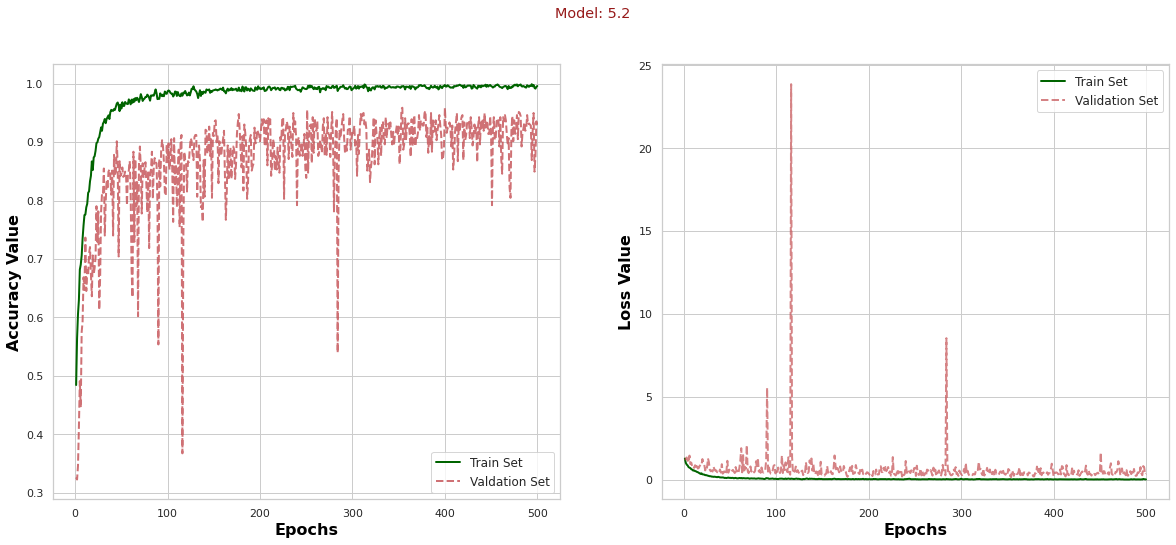

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

# TensorBoard configuration:
my_log_dir = os.path.join("my_log_dir", 
                    datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"+"(5.2)"))
tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, histogram_freq=1)

model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
# fit the set
model_history = model.fit(train_generator, 
                batch_size=32, 
                epochs=500, 
                verbose=0, 
                validation_data=validation_generator, 
                callbacks = [tensorboard_callbacks]
                )

display_graph("5.2")

In [ ]:
model.save("model52.h5")
model.evaluate(test_generator, batch_size=1)

188/188 [==============================] - 1s 3ms/step - loss: 0.2200 - accuracy: 0.9480


[0.2199549525976181, 0.9480000138282776]

### 3.1.3 Third Try
Changed: Number of neurons in the Dense layer got doubled.

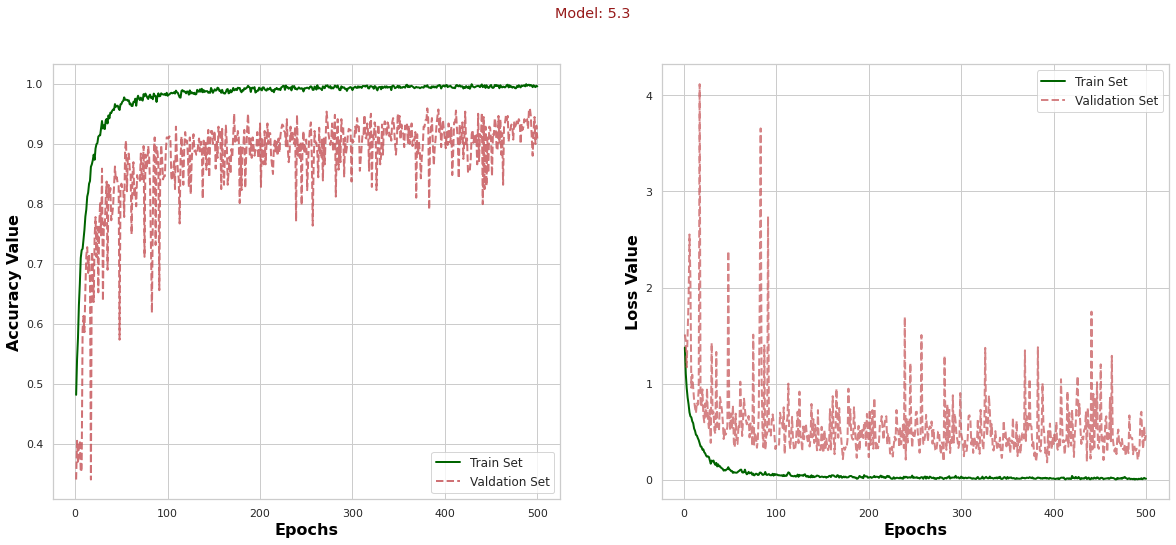

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

# TensorBoard configuration:
my_log_dir = os.path.join("my_log_dir", 
                    datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"+"(5.3)"))
tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, histogram_freq=1)

model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
# fit the set
model_history = model.fit(train_generator, 
                batch_size=32, 
                epochs=500, 
                verbose=0, 
                validation_data=validation_generator, 
                callbacks = [tensorboard_callbacks]
                )
display_graph("5.3")

In [ ]:
model.save("model53.h5")
model.evaluate(test_generator, batch_size=1)

188/188 [==============================] - 1s 3ms/step - loss: 0.2521 - accuracy: 0.9427


[0.2521270215511322, 0.9426666498184204]

### 3.1.4 Fourth Try
Changed: 1 more layer is added.

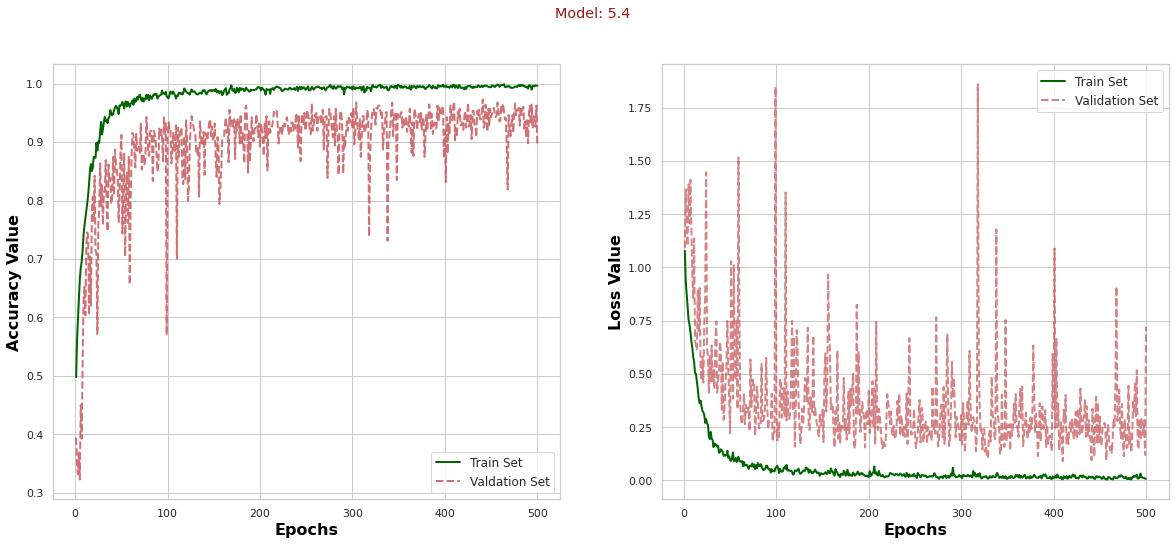

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

# TensorBoard configuration:
my_log_dir = os.path.join("my_log_dir", 
                    datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"+"(5.4)"))
tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, histogram_freq=1)

model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
# fit the set
model_history = model.fit(train_generator, 
                batch_size=32, 
                epochs=500, 
                verbose=0, 
                validation_data=validation_generator, 
                callbacks = [tensorboard_callbacks]
                )
display_graph("5.4")

In [ ]:
model.save("model54.h5")
model.evaluate(test_generator, batch_size=1)

188/188 [==============================] - 1s 3ms/step - loss: 0.2987 - accuracy: 0.9387


[0.2986612617969513, 0.9386666417121887]

### 3.1.5 Fifth Try
Changed: 2 more layers (Conv & Dense) are added!

Instructions for updating:
use `tf.profiler.experimental.stop` instead.


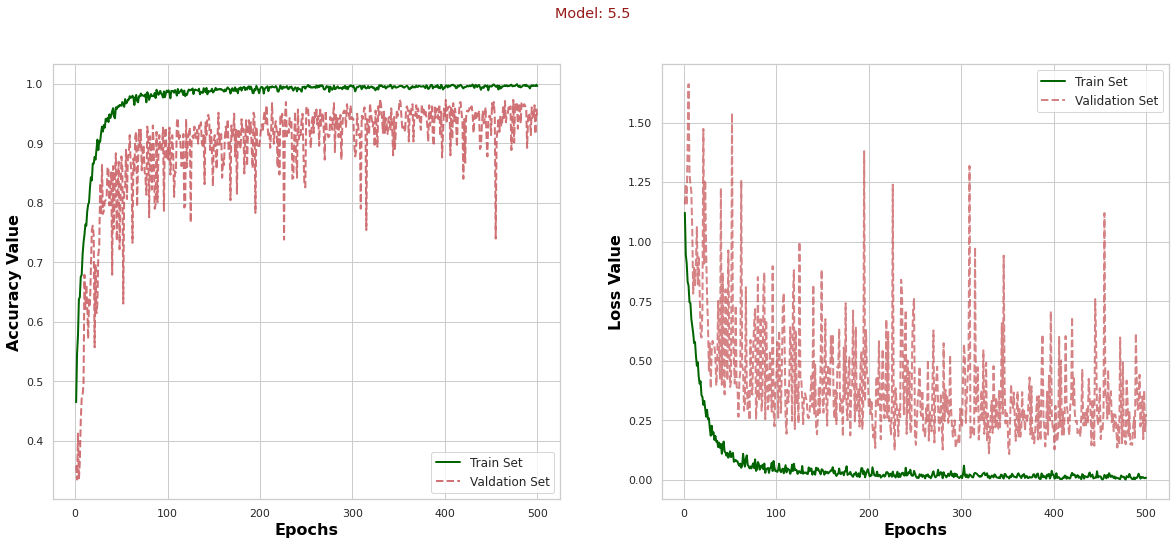

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=512, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=256, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

# TensorBoard configuration:
my_log_dir = os.path.join("my_log_dir", 
                    datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S"+"(5.5)"))
tensorboard_callbacks = TensorBoard(log_dir=my_log_dir, histogram_freq=1)

model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
# fit the set
model_history = model.fit(train_generator, 
                batch_size=32, 
                epochs=500, 
                verbose=0, 
                validation_data=validation_generator, 
                callbacks = [tensorboard_callbacks]
                )
display_graph("5.5")

In [ ]:
model.save("model55.h5")
model.evaluate(test_generator, batch_size=1)

188/188 [==============================] - 1s 5ms/step - loss: 0.2279 - accuracy: 0.9547


[0.22793523967266083, 0.9546666741371155]